In [1]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import torch.nn.functional as F
import random
import pickle as pkl

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.hed import HEDdetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from util_generate import process

%load_ext autoreload
%autoreload 2

/home/gridsan/qwang/.conda/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [2]:
version = '24305430'
epoch = '4'
step = '112594'
zoom = '16'
city_dic={'chicago': 'Chicago', 'dallas':'Dallas', 'la':'Los Angeles'}

In [6]:
desc = {}
select = {}
for c in ['chicago','la','dallas']:
    desc[c] = pd.read_csv("~/satellite_tiles_control/tile_descriptions/tile_descriptions_"+c+"_1114.csv").set_index(['xtile','ytile'])
    select[c] = pd.read_csv("~/satellite_tiles_control/tile_descriptions/"+c+"_select.csv")#.set_index(['xtile','ytile'])
    print(len(select[c]))

165
36
51


In [4]:
import os
os.makedirs('./lightning_logs/version_'+version+'/image_log/', exist_ok=True)

36


KeyboardInterrupt: 

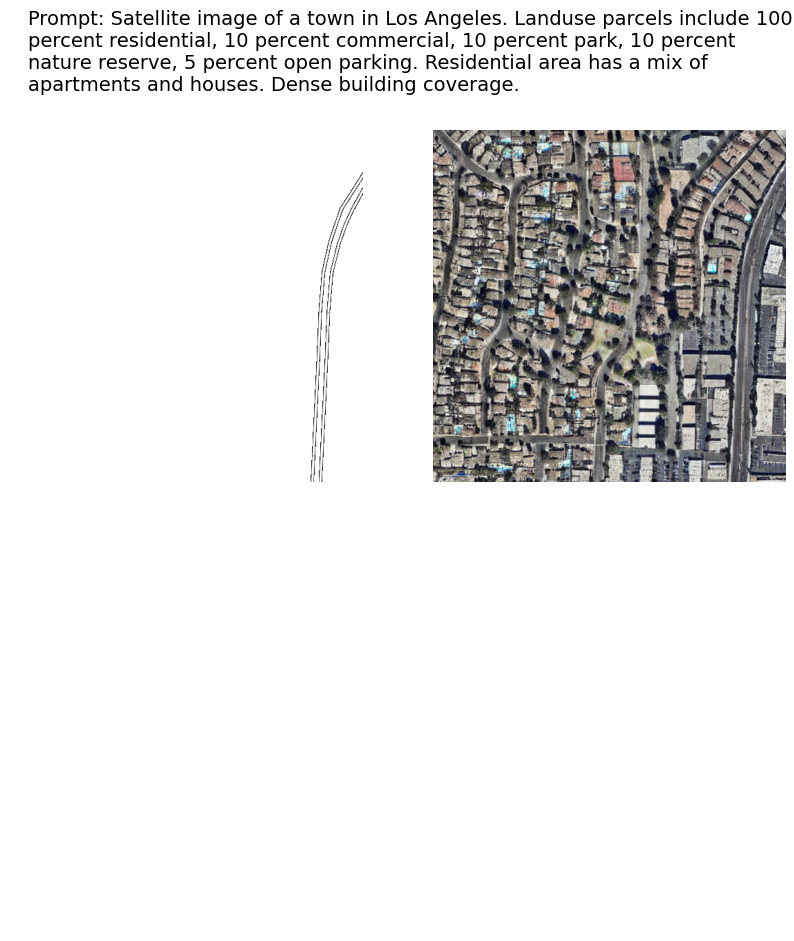

In [11]:
count = 0
x_list = []
y_list = []
ans = []

for city in ['la','dallas','chicago']:
    print(len(select[city]))
    
    for x, y in zip(select[city]['xtile'], select[city]['ytile']):
        
        true_image = cv2.imread("/home/gridsan/qwang/satellite_tiles_control/satellite_tiles/"+str(zoom)+"/"+city+"/"+str(zoom)+"_"+str(x)+"_"+str(y)+".png")
        detected_map = cv2.imread("/home/gridsan/qwang/satellite_tiles_control/skeleton/"+str(zoom)+"/"+city+"/"+str(x)+"/"+str(y)+".png", cv2.IMREAD_UNCHANGED)
        gen_image = cv2.imread("/home/gridsan/qwang/satellite_tiles_control/generation/"+version+"_"+epoch+"-"+step+"_"+city+"/"+str(x)+'_'+str(y)+'.png')
        
        if (true_image is not None) and (detected_map is not None) and (gen_image is not None):
            count += 1
            x_list.append(x)
            y_list.append(y)
            
            # convert 4-channel source image to 3-channel
            #make mask of where the transparent bits are
            trans_mask = detected_map[:,:,3] == 0

            #replace areas of transparency with white and not transparent
            detected_map[trans_mask] = [255, 255, 255, 255]

            #new image without alpha channel...
            detected_map = cv2.cvtColor(detected_map, cv2.COLOR_BGRA2BGR)     

            #convert all to RGB
            true_image = cv2.cvtColor(true_image, cv2.COLOR_BGR2RGB)
            detected_map = cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB)
            gen_image = cv2.cvtColor(gen_image, cv2.COLOR_BGR2RGB)

            description = desc[city].loc[(x,y)]['final_description']
        
            fig, ax = plt.subplots(1,2,figsize=(10,5));
            ax[0].imshow(detected_map);
            ans.append(1)
            ax[1].imshow(true_image);
            for a in ax.ravel():
                a.set_axis_off();

            ax[0].text(25, -175, "Prompt: " + description, fontsize=14, verticalalignment='top', wrap=True);
            # ax[1].text(256, 575, 'Design', fontsize=14, verticalalignment='top', horizontalalignment='center');
            
            box = matplotlib.transforms.Bbox([[1,0],[10,5.5]]);
            fig.savefig('./lightning_logs/version_'+version+'/image_log/'+str(count)+'-1.png', bbox_inches=box);
            
            
            ax[1].imshow(gen_image); 
            fig.savefig('./lightning_logs/version_'+version+'/image_log/'+str(count)+'-2.png', bbox_inches=box);

            plt.close()
        else:
            print(city, x, y)


In [8]:
count = 0
x_list = []
y_list = []
ans = []

for city in ['la','dallas','chicago']:
    for x, y in zip(select[city]['xtile'], select[city]['ytile']):
        
        true_image = cv2.imread("/home/gridsan/qwang/satellite_tiles_control/satellite_tiles/"+str(zoom)+"/"+city+"/"+str(zoom)+"_"+str(x)+"_"+str(y)+".png")
        detected_map = cv2.imread("/home/gridsan/qwang/satellite_tiles_control/skeleton/"+str(zoom)+"/"+city+"/"+str(x)+"/"+str(y)+".png", cv2.IMREAD_UNCHANGED)
        gen_image = cv2.imread("/home/gridsan/qwang/satellite_tiles_control/generation/"+version+"_"+epoch+"-"+step+"_"+city+"/"+str(x)+'_'+str(y)+'.png')
        
        if (true_image is not None) and (detected_map is not None) and (gen_image is not None):
            count += 1
            x_list.append(x)
            y_list.append(y)
            
            # convert 4-channel source image to 3-channel
            #make mask of where the transparent bits are
            trans_mask = detected_map[:,:,3] == 0

            #replace areas of transparency with white and not transparent
            detected_map[trans_mask] = [255, 255, 255, 255]

            #new image without alpha channel...
            detected_map = cv2.cvtColor(detected_map, cv2.COLOR_BGRA2BGR)     

            #convert all to RGB
            true_image = cv2.cvtColor(true_image, cv2.COLOR_BGR2RGB)
            detected_map = cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB)
            gen_image = cv2.cvtColor(gen_image, cv2.COLOR_BGR2RGB)

            description = desc[city].loc[(x,y)]['final_description']
            fig, ax = plt.subplots(1,3,figsize=(12,4));
            ax[0].imshow(detected_map);
            if np.random.rand() <  0.5:
                ans.append(1)
                ax[1].imshow(true_image);
                ax[2].imshow(gen_image);
            else:
                ans.append(2)
                ax[1].imshow(gen_image);
                ax[2].imshow(true_image);
            for a in ax.ravel():
                a.set_axis_off();

            ax[0].text(25, -175, "Prompt: " + description, fontsize=14, verticalalignment='top', wrap=True);
            ax[1].text(256, 575, 'Design 1', fontsize=14, verticalalignment='top', horizontalalignment='center');
            ax[2].text(256, 575, 'Design 2', fontsize=14, verticalalignment='top', horizontalalignment='center');

            box = matplotlib.transforms.Bbox([[1.4,0],[12,4.5]]);
            fig.savefig('./lightning_logs/version_'+version+'/image_log/'+str(count)+'.png', bbox_inches=box);
            plt.close()
     

In [9]:
count

144

In [10]:
pd.DataFrame(np.array([x_list, y_list, ans]).T, columns=['xtile','ytile','ans']).to_csv("./ans_20231222.csv", index=True)